In [1]:
import datetime
import pandas as pd
from influxdb import DataFrameClient
import matplotlib
import matplotlib.pyplot as plt
import json
import pytz
import numpy as np
from sklearn.linear_model import LinearRegression
import yaml
%matplotlib inline

In [2]:
with open('uuid_map.json') as fp:
    uuid_map = json.load(fp)

In [3]:
with open('config.yaml') as fp:
    config = yaml.safe_load(fp)
database_config = config.get('database')

In [4]:
client = DataFrameClient(
    host=database_config.get('host'), 
    port=database_config.get('port'), 
    username=database_config.get('username'), 
    password=database_config.get('password'), 
    database=database_config.get('database'), 
    ssl=database_config.get('ssl'), 
    verify_ssl=database_config.get('verify_ssl')
)

In [5]:
tz_local = pytz.timezone('America/Los_Angeles')
tz_utc = pytz.timezone('UTC')

In [6]:
uuid_dict = {
    'building_power': uuid_map['xbos/wattnode/building_main/PowerSum'],
    'freezer_power': uuid_map['xbos/wattnode/fre_comp_evapfan/PowerSum'],
    'ref_comp_power': uuid_map['xbos/wattnode/ref_comp/PowerSum'],
    'ref_fan_power': uuid_map['xbos/wattnode/ref_evapfan/PowerSum'],
    'hvac_west_power': uuid_map['xbos/wattnode/hvac_west_comp/PowerSum'],
    'hvac_east_power': uuid_map['xbos/wattnode/hvac_east_comp/PowerSum'],
    
    'east_temperature': uuid_map['xbos/flexstat/thermostat_east/space_temp'],
    'west_temperature': uuid_map['xbos/flexstat/thermostat_west/space_temp'],
    'freezer_temperature': uuid_map['xbos/parker/freezer/CabinetTemperature'],
    'ref_temperature': uuid_map['xbos/parker/refrigerator/CabinetTemperature'],
    
    'east_heating_sp': uuid_map['xbos/flexstat/thermostat_east/active_heating_setpt'],
    'east_cooling_sp': uuid_map['xbos/flexstat/thermostat_east/active_cooling_setpt'],
    'west_heating_sp': uuid_map['xbos/flexstat/thermostat_west/active_heating_setpt'],
    'west_cooling_sp': uuid_map['xbos/flexstat/thermostat_west/active_cooling_setpt'],
    'freezer_sp': uuid_map['xbos/parker/freezer/Setpoint'],
    'ref_sp': uuid_map['xbos/parker/refrigerator/Setpoint'],
    
    'soc_battery': '0efc4fa5-755c-5c45-863a-c0c776ab7538',
    'setpoint_battery': '276ea28f-0f74-5b3e-9ad1-f3b9f747dbe4',
    'pv_generation_battery': 'fdfd7bbb-d2da-5b11-a8fa-58b231ab9802',
    
    'oat_current': 'f7c1f2c8-c996-528c-ab3d-bdc96dc9cf72',
    'humidity_current': '7967b372-2699-57e1-bc15-7861bfe6d024',
    'windspeed_current': 'ac555599-0403-5bea-8441-f39a4e8e0dac',
    'cloudcover_current': '6cce3e9a-3822-551b-b13c-f4b874f3afa1',
    'solar_current': 'd15979be-7a63-5230-9e7b-d068d9f40b08',
    'sr_current': 'd15979be-7a63-5230-9e7b-d068d9f40b08',
    
    'oat_forecast': '69be4db0-48f5-592f-b5a1-e2e695f28ad1',
    'humidity_forecast': 'c2379487-3df3-5bfe-bd8d-5992d2381ed5',
    'windspeed_forecast': '837d0588-b30a-56ee-920f-cf366fa0871f',
    'cloudcover_forecast': '6f93857f-50a6-5b9f-8b94-0231f511b382',
    'solar_forecast': 'a8357adb-c59d-5316-a0e8-51d2b2948c75',
    
    'price_energy_dr': '3be4c234-a38a-5e73-9d53-4503751592be',
    'price_demand_dr': '90928e8d-df40-5e75-9ddb-7ee444bc187f',
    'pmax_dr': '522605a9-77b1-57e3-9fac-06dd83ab8e89',
    'pmin_dr': '6b42adf8-3a48-5ae7-bdc3-19226e602865',
}

In [7]:
def parse_dt_utc(dt):
    return tz_local.localize(datetime.datetime.strptime(dt, "%Y-%m-%d %H:%M:%S")).astimezone(tz_utc)

In [8]:
def current_uuid_data(client, uuid, st, et, column_name):
    st_utc = parse_dt_utc(st).strftime("%Y-%m-%dT%H:%M:%SZ")
    et_utc = parse_dt_utc(et).strftime("%Y-%m-%dT%H:%M:%SZ")
    query = "select value from timeseries where \"uuid\" = '%s' and time>= '%s' and time <= '%s'" % (uuid, st_utc, et_utc)
    df = client.query(query)['timeseries']
    df = df[['value']]
    df.columns = [column_name]
    return df

In [9]:
def forecast_uuid_data(client, uuid, st, et, column_name):
    st_utc = parse_dt_utc(st).strftime("%Y-%m-%dT%H:%M:%SZ")
    et_utc = parse_dt_utc(et).strftime("%Y-%m-%dT%H:%M:%SZ")
    query = "select value from timeseries where \"uuid\" = '%s' and \"prediction_step\" = '1' and time>= '%s' and time <= '%s'" % (uuid, st_utc, et_utc)
    df = client.query(query)['timeseries']
    df = df[['value']]
    df.columns = [column_name]
    return df

In [10]:
def get_data_section(client, endswith, st, et, uuid_dict, resample='1T', current=True):
    df_list = []
    for variable in uuid_dict:
        if variable.endswith(endswith):
            uuid = uuid_dict[variable]
            if current:
                df = current_uuid_data(client, uuid, st, et, column_name=variable[:variable.rfind('_')])
            else:
                df = forecast_uuid_data(client, uuid, st, et, column_name=variable[:variable.rfind('_')])
            df = df.resample(resample).mean()
            df_list.append(df)
    return pd.concat(df_list, axis=1)

In [11]:
st = "2020-07-19 00:00:00"
et = "2020-08-02 23:59:59"

In [12]:
power_df = get_data_section(client, '_power', st, et, uuid_dict, '1T')
power_df = power_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean()#.interpolate('linear').resample('30T').mean()
power_df.head()

,building,freezer,ref_comp,ref_fan,hvac_west,hvac_east
2020-07-19 00:00:00,34176.875000,4044.173828,14.919643,442.498840,2939.602051,3241.283203
2020-07-19 00:01:00,33548.640625,4026.793457,9.962272,42.042839,2922.791992,3238.636719
2020-07-19 00:02:00,39468.203125,3994.485596,4270.938965,447.384949,NaN,NaN
2020-07-19 00:03:00,NaN,NaN,NaN,NaN,2926.823730,3233.962891
2020-07-19 00:04:00,34266.390625,3978.000977,13.444770,443.142883,2931.019287,3234.100342


In [13]:
weather_df = get_data_section(client, '_current', st, et, uuid_dict, '1T')
weather_df = weather_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean().interpolate('linear')#.resample('15T').mean()
weather_df.head()

,oat,humidity,windspeed,cloudcover,solar,sr
2020-07-19 00:02:00,60.720000,76.0,1.900000,0.02,0.0,0.0
2020-07-19 00:03:00,60.714667,76.0,1.903333,0.02,0.0,0.0
2020-07-19 00:04:00,60.709333,76.0,1.906667,0.02,0.0,0.0
2020-07-19 00:05:00,60.704000,76.0,1.910000,0.02,0.0,0.0
2020-07-19 00:06:00,60.698667,76.0,1.913333,0.02,0.0,0.0


In [14]:
battery_df = get_data_section(client, '_battery', st, et, uuid_dict, '1T')
battery_df = battery_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean()#.resample('15T').mean()

# changing pv to new value 
battery_df.pv_generation = weather_df.sr*0.2*1.5*300

battery_df.head()

,soc,setpoint,pv_generation
2020-07-19 00:00:00,0.674426,0.0,NaN
2020-07-19 00:01:00,0.674426,0.0,NaN
2020-07-19 00:02:00,0.674426,0.0,0.0
2020-07-19 00:03:00,0.674426,0.0,0.0
2020-07-19 00:04:00,0.674426,0.0,0.0


In [15]:
X = power_df[['building']]
X.columns = ['net_load']
# X['pv'] = battery_df.pv_generation
X['oat'] = weather_df['oat']
# X.net_load = X.net_load - X.pv
# X = X.drop(columns=['pv']).dropna().resample('30T').mean()
X = X.dropna().resample('30T').mean()
X['tod'] = X.index.hour * 60 + X.index.minute
X['dow'] = X.index.weekday

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
X.head()

,net_load,oat,tod,dow
2020-07-19 00:00:00,36396.911855,60.652986,0,6
2020-07-19 00:30:00,34585.441406,60.468747,30,6
2020-07-19 01:00:00,32977.975210,60.227718,60,6
2020-07-19 01:30:00,33934.786784,59.592148,90,6
2020-07-19 02:00:00,35473.382546,58.795840,120,6


In [17]:
reg = LinearRegression().fit(X[['oat', 'tod', 'dow']], X['net_load'])

## change the test date below

In [18]:
test_date = "2020-09-05"

In [19]:
q_latest_ts = "select last(value), time from timeseries where time > now() - 13m and \"uuid\"='%s'"%(uuid_dict['oat_forecast'])
latest_ts_res = client.query(q_latest_ts)

In [20]:
latest_ts = latest_ts_res['timeseries'].index.values[0].astype('uint64')

In [21]:
q_solar_forecast = "select prediction_time, value from %s where \"uuid\"=\'%s\'" % ('timeseries', uuid_dict['solar_forecast'])
q_solar_forecast += " and time= " + (str(latest_ts))
test_weather_df1 = client.query(q_solar_forecast)['timeseries']
test_weather_df1 = test_weather_df1[['prediction_time', 'value']]
test_weather_df1.prediction_time = pd.to_datetime(test_weather_df1.prediction_time.astype(int) * 1e9)
test_weather_df1 = test_weather_df1.sort_values(by='prediction_time').set_index('prediction_time').tz_localize(tz_utc)
test_weather_df1.index.name = 'time'
test_weather_df1.columns = ['pv']

q_oat_forecast = "select prediction_time, value from %s where \"uuid\"=\'%s\'" % ('timeseries', uuid_dict['oat_forecast'])
q_oat_forecast += " and time= " + (str(latest_ts))
test_weather_df2 = client.query(q_oat_forecast)['timeseries']
test_weather_df2 = test_weather_df2[['prediction_time', 'value']]
test_weather_df2.prediction_time = pd.to_datetime(test_weather_df2.prediction_time.astype(int) * 1e9)
test_weather_df2 = test_weather_df2.sort_values(by='prediction_time').set_index('prediction_time').tz_localize(tz_utc)
test_weather_df2.index.name = 'time'
test_weather_df2.columns = ['oat']

test_weather_forecast_df = pd.concat([test_weather_df1, test_weather_df2], axis=1)

In [22]:
test_weather_forecast_df.head()

,pv,oat
time,,
2020-09-04 20:00:00+00:00,274.858686,63.37
2020-09-04 21:00:00+00:00,246.181632,64.03
2020-09-04 22:00:00+00:00,214.628339,64.64
2020-09-04 23:00:00+00:00,412.495702,64.50
2020-09-05 00:00:00+00:00,318.893907,63.57


In [23]:
test_st = test_date+" 00:00:00"
test_et = test_date+" 23:59:59"

test_st = tz_local.localize(datetime.datetime.strptime(test_st, "%Y-%m-%d %H:%M:%S")).astimezone(tz_utc)
test_et = tz_local.localize(datetime.datetime.strptime(test_et, "%Y-%m-%d %H:%M:%S")).astimezone(tz_utc)

test_weather_df = test_weather_forecast_df.loc[test_st: test_et]
test_weather_df

,pv,oat
time,,
2020-09-05 07:00:00+00:00,0.000000,53.43
2020-09-05 08:00:00+00:00,0.000000,53.07
2020-09-05 09:00:00+00:00,0.000000,52.51
2020-09-05 10:00:00+00:00,0.000000,51.44
2020-09-05 11:00:00+00:00,0.000000,51.08
2020-09-05 12:00:00+00:00,0.000000,51.18
2020-09-05 13:00:00+00:00,0.000000,51.12
2020-09-05 14:00:00+00:00,0.000000,51.61
2020-09-05 15:00:00+00:00,133.323380,52.91


In [24]:
Y = test_weather_df[['oat']]
Y = Y.resample('30T').mean().interpolate(method='linear')
Y['tod'] = Y.index.hour * 60 + Y.index.minute
Y['dow'] = Y.index.weekday
Y['net_load'] = reg.predict(Y)

In [25]:
Y.head()

,oat,tod,dow,net_load
time,,,,
2020-09-05 07:00:00+00:00,53.43,420,5,34849.809131
2020-09-05 07:30:00+00:00,53.25,450,5,34898.623353
2020-09-05 08:00:00+00:00,53.07,480,5,34947.437576
2020-09-05 08:30:00+00:00,52.79,510,5,34988.262012
2020-09-05 09:00:00+00:00,52.51,540,5,35029.086448


/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


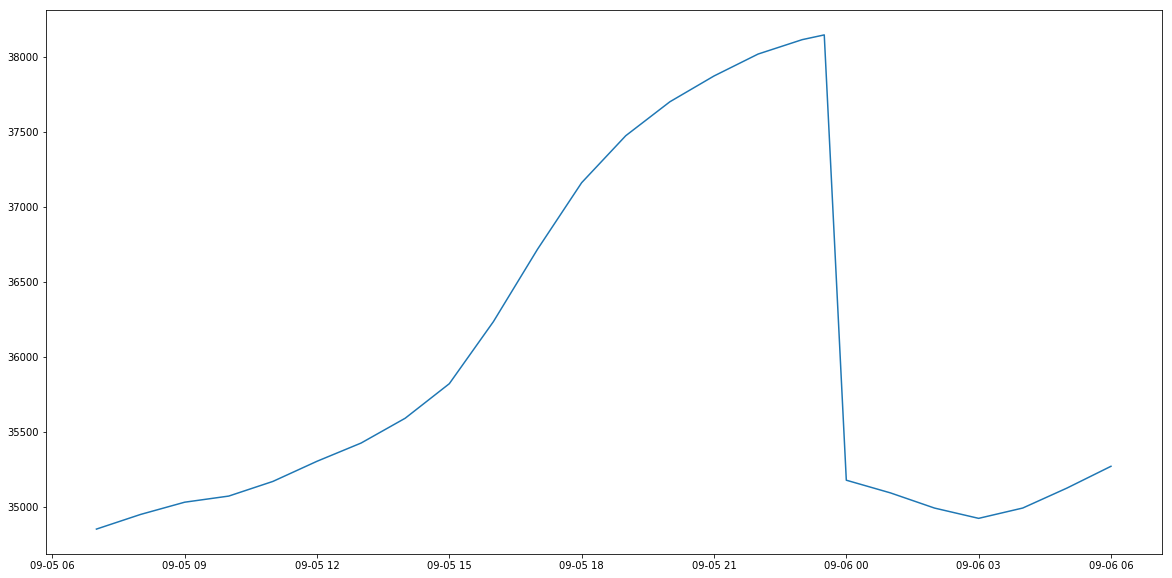

In [26]:
plt.figure(figsize=(20,10))
plt.plot(Y.tz_convert(tz_local).net_load)

In [27]:
Y.tz_convert(tz_local)[test_date].net_load

time
2020-09-05 00:00:00-07:00    34849.809131
2020-09-05 00:30:00-07:00    34898.623353
2020-09-05 01:00:00-07:00    34947.437576
2020-09-05 01:30:00-07:00    34988.262012
2020-09-05 02:00:00-07:00    35029.086448
2020-09-05 02:30:00-07:00    35049.536928
2020-09-05 03:00:00-07:00    35069.987407
2020-09-05 03:30:00-07:00    35118.801630
2020-09-05 04:00:00-07:00    35167.615853
2020-09-05 04:30:00-07:00    35234.806586
2020-09-05 05:00:00-07:00    35301.997319
2020-09-05 05:30:00-07:00    35362.796222
2020-09-05 06:00:00-07:00    35423.595125
2020-09-05 06:30:00-07:00    35506.365943
2020-09-05 07:00:00-07:00    35589.136760
2020-09-05 07:30:00-07:00    35704.266215
2020-09-05 08:00:00-07:00    35819.395670
2020-09-05 08:30:00-07:00    36026.407675
2020-09-05 09:00:00-07:00    36233.419679
2020-09-05 09:30:00-07:00    36474.787768
2020-09-05 10:00:00-07:00    36716.155856
2020-09-05 10:30:00-07:00    36937.948967
2020-09-05 11:00:00-07:00    37159.742078
2020-09-05 11:30:00-07:00    

In [28]:
test_weather_df.tz_convert(tz_local)[test_date].pv * 272.6 * 0.26 * 0.98

time
2020-09-05 00:00:00-07:00        0.000000
2020-09-05 01:00:00-07:00        0.000000
2020-09-05 02:00:00-07:00        0.000000
2020-09-05 03:00:00-07:00        0.000000
2020-09-05 04:00:00-07:00        0.000000
2020-09-05 05:00:00-07:00        0.000000
2020-09-05 06:00:00-07:00        0.000000
2020-09-05 07:00:00-07:00        0.000000
2020-09-05 08:00:00-07:00     9260.439343
2020-09-05 09:00:00-07:00    21423.271548
2020-09-05 10:00:00-07:00    33107.928811
2020-09-05 11:00:00-07:00    37929.116092
2020-09-05 12:00:00-07:00    35796.687092
2020-09-05 13:00:00-07:00    32840.120365
2020-09-05 14:00:00-07:00    32117.458530
2020-09-05 15:00:00-07:00    30965.968461
2020-09-05 16:00:00-07:00    27524.075409
2020-09-05 17:00:00-07:00    20515.386549
2020-09-05 18:00:00-07:00    10881.187374
2020-09-05 19:00:00-07:00     2376.113914
2020-09-05 20:00:00-07:00        0.000000
2020-09-05 21:00:00-07:00        0.000000
2020-09-05 22:00:00-07:00        0.000000
2020-09-05 23:00:00-07:00    

In [29]:
Y.tz_convert(tz_local)[test_date].net_load - test_weather_df.tz_convert(tz_local)[test_date].resample('30T').interpolate().pv * 272.6 * 0.26 * 0.98

time
2020-09-05 00:00:00-07:00    34849.809131
2020-09-05 00:30:00-07:00    34898.623353
2020-09-05 01:00:00-07:00    34947.437576
2020-09-05 01:30:00-07:00    34988.262012
2020-09-05 02:00:00-07:00    35029.086448
2020-09-05 02:30:00-07:00    35049.536928
2020-09-05 03:00:00-07:00    35069.987407
2020-09-05 03:30:00-07:00    35118.801630
2020-09-05 04:00:00-07:00    35167.615853
2020-09-05 04:30:00-07:00    35234.806586
2020-09-05 05:00:00-07:00    35301.997319
2020-09-05 05:30:00-07:00    35362.796222
2020-09-05 06:00:00-07:00    35423.595125
2020-09-05 06:30:00-07:00    35506.365943
2020-09-05 07:00:00-07:00    35589.136760
2020-09-05 07:30:00-07:00    31074.046544
2020-09-05 08:00:00-07:00    26558.956327
2020-09-05 08:30:00-07:00    20684.552229
2020-09-05 09:00:00-07:00    14810.148131
2020-09-05 09:30:00-07:00     9209.187588
2020-09-05 10:00:00-07:00     3608.227045
2020-09-05 10:30:00-07:00     1419.426515
2020-09-05 11:00:00-07:00     -769.374015
2020-09-05 11:30:00-07:00    

In [120]:
[10000, 10000, 11000, 11000, 12000, 12000, 19000, 19000, 26000, 26000, 26000, 26000, 26000]

[10000,
 10000,
 11000,
 11000,
 12000,
 12000,
 19000,
 19000,
 26000,
 26000,
 26000,
 26000,
 26000]